# Model-Based Reinforcement Learning

## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with *sparse rewards*, the chance of obtaining a reward randomly is *negligible*, which prevents any learning.
* However, even in the *absence of rewards* we still receive a *stream of state transition data*. We could use this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have *complex* dynamics but a *simple* optimal policy or value function. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have simple dynamics but complex policies/value functions. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular *structure*: for instance, any problem involving motion of physical objects will be *continuous*. It can only be *smooth*, invariant to *translations*, etc. This knowledge can then me incorporated in machine learning models to foster efficient learning. In contrast, there can often be discontinuities in the policy decisions or value function (think of a collision vs near-collision state).

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to learn faster than model-free techniques. [ref. needed]

## Principle
We consider the optimal control problem of an MDP with a *known* reward function $R$ and subject to *unknown deterministic* dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In model-based reinforcement learning, this problem is split into two subtasks:
1. *Model learning*:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. *Planning*:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

## Warming up
We start with a few useful imports.

In [7]:
# Environment
import gym
import highway_env

# Modelling
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt


## Experience collection
First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [16]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])



def collect_interaction_data(env, size=1000):
    data, done = [], True
    for _ in range(size):
        previous_obs = env.reset() if done else obs
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        data.append(Transition(torch.Tensor(previous_obs["observation"]),
                               torch.Tensor(action),
                               torch.Tensor(obs["observation"])))
    return data


env = gym.make("parking-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0826, 0.9966]), action=tensor([ 0.4731, -0.6822]), next_state=tensor([2.6326e-05, 3.1433e-04, 8.1724e-03, 9.4274e-02, 8.6363e-02, 9.9626e-01]))


## Build dynamics model

We choose to represent the dynamics using a structured model inspired from *LTI models* (Linear Time-Invariant):

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

Intuitively, we learn at each point $(x_t, u_t)$ the linearization of the true dynamics model $f_\theta$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [17]:
class DynamicsModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super().__init__()
        self.state_size, self.action_size = state_size, action_size
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u, dt=1.0):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            u = u.unsqueeze(0)
        xu = torch.cat((x, u), -1)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze() * dt


dynamics = DynamicsModel(env.observation_space.spaces["observation"].shape[0],
                         env.action_space.shape[0],
                         10)
print("Forward model on sample transition:", dynamics(data[0].state, data[0].action))

Forward model on sample transition: tensor([[ 0.1250,  0.2090,  0.1265, -0.2860,  0.2768,  1.2961]],
       grad_fn=<AddBackward0>)


## Training helpers
We define some simple functions to manipulate the batch and define the model loss:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t))||^2$$

In [18]:
def transpose_batch(data):
    zipped = Transition(*zip(*data))
    states = torch.stack(zipped.state)
    actions = torch.stack(zipped.action)
    next_states = torch.stack(zipped.next_state)
    return states, actions, next_states

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states), predictions

def visualize(data_t, predictions):
    plt.cla()
    states, actions, next_states = data_t
    delta_x = next_states.data.numpy() - states.data.numpy()
    pred_delta_x = predictions.data.numpy() - states.data.numpy()
    actions = actions.data.numpy()
    plt.scatter(actions[:, 0], delta_x[:, 2], label="true")
    plt.scatter(actions[:, 0], pred_delta_x[:, 2], label="predicted")
    plt.xlabel("acceleration")
    plt.ylabel("vx variation")
    plt.pause(0.1)

## Fit model on data
We can now train the model to minimize an MSE loss over our experience batch $D$ by stochastic gradient descent:

$$\min_\theta L^2(f_\theta; D)$$

[1/500] Training loss: 1.447E-01, validation loss: 1.230E-01
[100/500] Training loss: 5.580E-04, validation loss: 4.978E-03
[200/500] Training loss: 2.604E-04, validation loss: 3.729E-03
[300/500] Training loss: 1.664E-04, validation loss: 3.441E-03
[400/500] Training loss: 1.212E-04, validation loss: 3.431E-03
[500/500] Training loss: 9.569E-05, validation loss: 3.503E-03


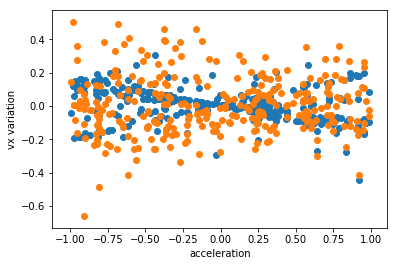

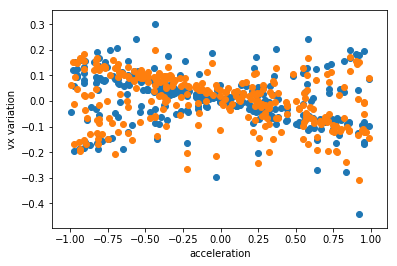

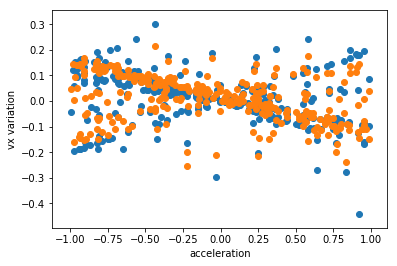

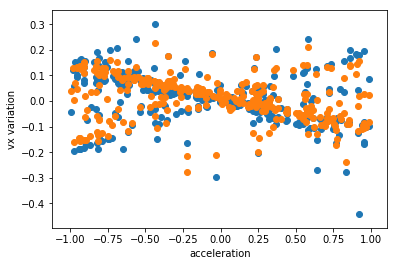

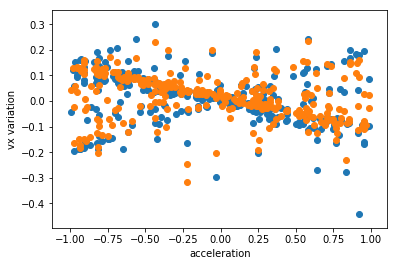

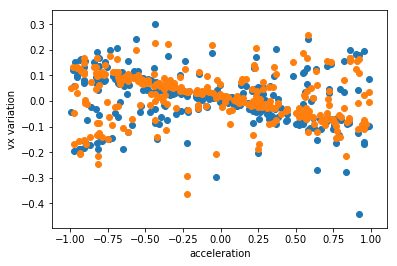

In [19]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
data, validation_data = data[:int(train_ratio * len(data))], \
                        data[int(train_ratio * len(data)):]

def train(model, data, validation_data, epochs=500):
    data_t = transpose_batch(data)
    validation_data_t = transpose_batch(validation_data)
    for epoch in range(epochs):
        loss, _ = compute_loss(model, data_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Monitor training
        if (epoch + 1) % (epochs // 5) == 0 or epoch == 0:
            validation_loss, predictions = compute_loss(model, validation_data_t)
            print("[{}/{}] Training loss: {:.3E}, validation loss: {:.3E}".format(
                epoch+1, epochs, loss.data.numpy(), validation_loss.detach().data.numpy()))
            visualize(validation_data_t, predictions)
        plt.ioff()
        plt.show()

train(dynamics, data, validation_data)

## Leverage model for planning


## Limits

### Model bias

In model-based reinforcement learning, we solve for the optimal control of the learnt MDP instead of the original MDP. This can lead to sub-optimality or even dramatic performance loss when the learnt model is not close enough to the true dynamics.

Hence, when settling for an approximate model to plan with we introduce a bias that can only decrease the performance of the corresponding policy. This is called the model bias.